_Version log: Optimisation using Principle Component Analysis._

In [1]:
import sys, warnings, os
from sklearn.linear_model import Lasso #I'm using scikit insted of svxpy to solve.
from sklearn.exceptions import ConvergenceWarning
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft as spfft, linalg as spla
from tqdm import tqdm
warnings.filterwarnings("ignore", category= ConvergenceWarning)
plt.rcParams.update({'font.size':16})
np.set_printoptions(threshold=sys.maxsize)

In [2]:
def open_dataset(file_name, file_type):
    if file_type == ".csv":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
        if array.ndim == 2:
            return array.T
    elif file_type == ".txt":
        array = np.genfromtxt("data\\" +file_name +file_type, delimiter=",", filling_values= np.nan)
    else:
        raise ValueError("{0:} is not a regonised file type.".format(file_type))
    return array

def compressed_sensing(samples, locations, total_points, alpha):

    cropping_matrix = np.identity(total_points, dtype= np.float16)
    cropping_matrix = cropping_matrix[locations] #cropping matrix operator
    dct_matrix = spfft.idct(np.identity(total_points), axis= 0, norm= "forward")
    measurement_matrix = np.matmul(cropping_matrix, dct_matrix)

    lasso = Lasso(alpha= alpha)
    lasso.fit(measurement_matrix, samples)

    result = spfft.idct(lasso.coef_, norm= "forward")

    return result


def subsample_1d(total_points, subsampling_percentage = 0.5, subsampling_method = "random"):
    reduced_points = round(total_points *subsampling_percentage)

    if subsampling_method == "random":
        subsampled_points = np.random.choice(total_points, reduced_points, replace= False)
    elif subsampling_method == "regular":
        subsampled_points = np.round(np.linspace(0, total_points -1, reduced_points)).astype(int)
    elif subsampling_method == "centered":
        subsampled_points = np.arange((total_points-reduced_points)//2, (total_points+reduced_points)//2)

    subsampled_points = np.sort(subsampled_points) #Nessisary only for optimisation.

    return subsampled_points

In [3]:
############ STEVEN BRUNTONS RPCA IMPELMENTATION ###############
### I don't fully understand what is going on here but I've added some comments.

def shrink(X,tau):
    Y = np.abs(X)-tau
    return np.sign(X) * np.maximum(Y,np.zeros_like(Y))
def SVT(X,tau): #Singular Value Thresholding?
    U,S,VT = np.linalg.svd(X,full_matrices=0) #Singular value decomposition
    out = U @ np.diag(shrink(S,tau)) @ VT
    return out
def RPCA(X): #Robust Principal Component Analysis
    n1,n2 = X.shape #n1 is the number of pixels. n2 is the number of faces.
    mu = n1*n2/(4*np.sum(np.abs(X.reshape(-1)))) # (mean) normalisation coeffient
    lambd = 1/np.sqrt(np.maximum(n1,n2)) # (standard deivation) normalisation coeffient
    thresh = 10**(-10) * np.linalg.norm(X) #Iterations will continue until the residuals are 10^10 times smaller than the norm of the faces. 
    
    S = np.zeros_like(X) #initialise error matrix. We want this matrix to be sparse.
    Y = np.zeros_like(X) #initialise the Lagrange multiplier matrix. It perturbs the solution at each iteration and represents the rate of change in the optimisation.
    L = np.zeros_like(X) #initialise principal component matrix. We want this matrix to be low rank (represents few dimentions).
    for count in tqdm(range(1000)): #Iterate until converged or a maximum number of iterations has been reached.
        L = SVT(X-S+(1/mu)*Y,1/mu) #1/mu is 4* average pixel value. 
        S = shrink(X-L+(1/mu)*Y,lambd/mu)
        Y = Y + mu*(X-L-S)
        if np.linalg.norm(X-L-S) < thresh:
            break
    return L,S,Y

In [4]:
training_dataset = 2

training_directory = "data\\training_set{0:}\\".format(training_dataset)
training_file_paths = [os.path.join(training_directory, file_name) for file_name in os.listdir(training_directory)]

training_data = np.array([np.genfromtxt(file_path, delimiter=",", filling_values= np.nan) for file_path in training_file_paths])

training_data = np.rollaxis(training_data, -1, 0) # move the last axis to the front
training_interferograms, training_uncertainty = training_data # now we can seperate the interferograms from the uncertainties. :)

training_interferograms.shape

(900, 200)

In [5]:
components, sparse_errors, lagrange_multiplier = RPCA(training_interferograms.T)
components, sparse_errors, lagrange_multiplier = components.T, sparse_errors.T, lagrange_multiplier.T 

  0%|          | 0/1000 [00:00<?, ?it/s]

 68%|██████▊   | 685/1000 [02:29<01:08,  4.60it/s]


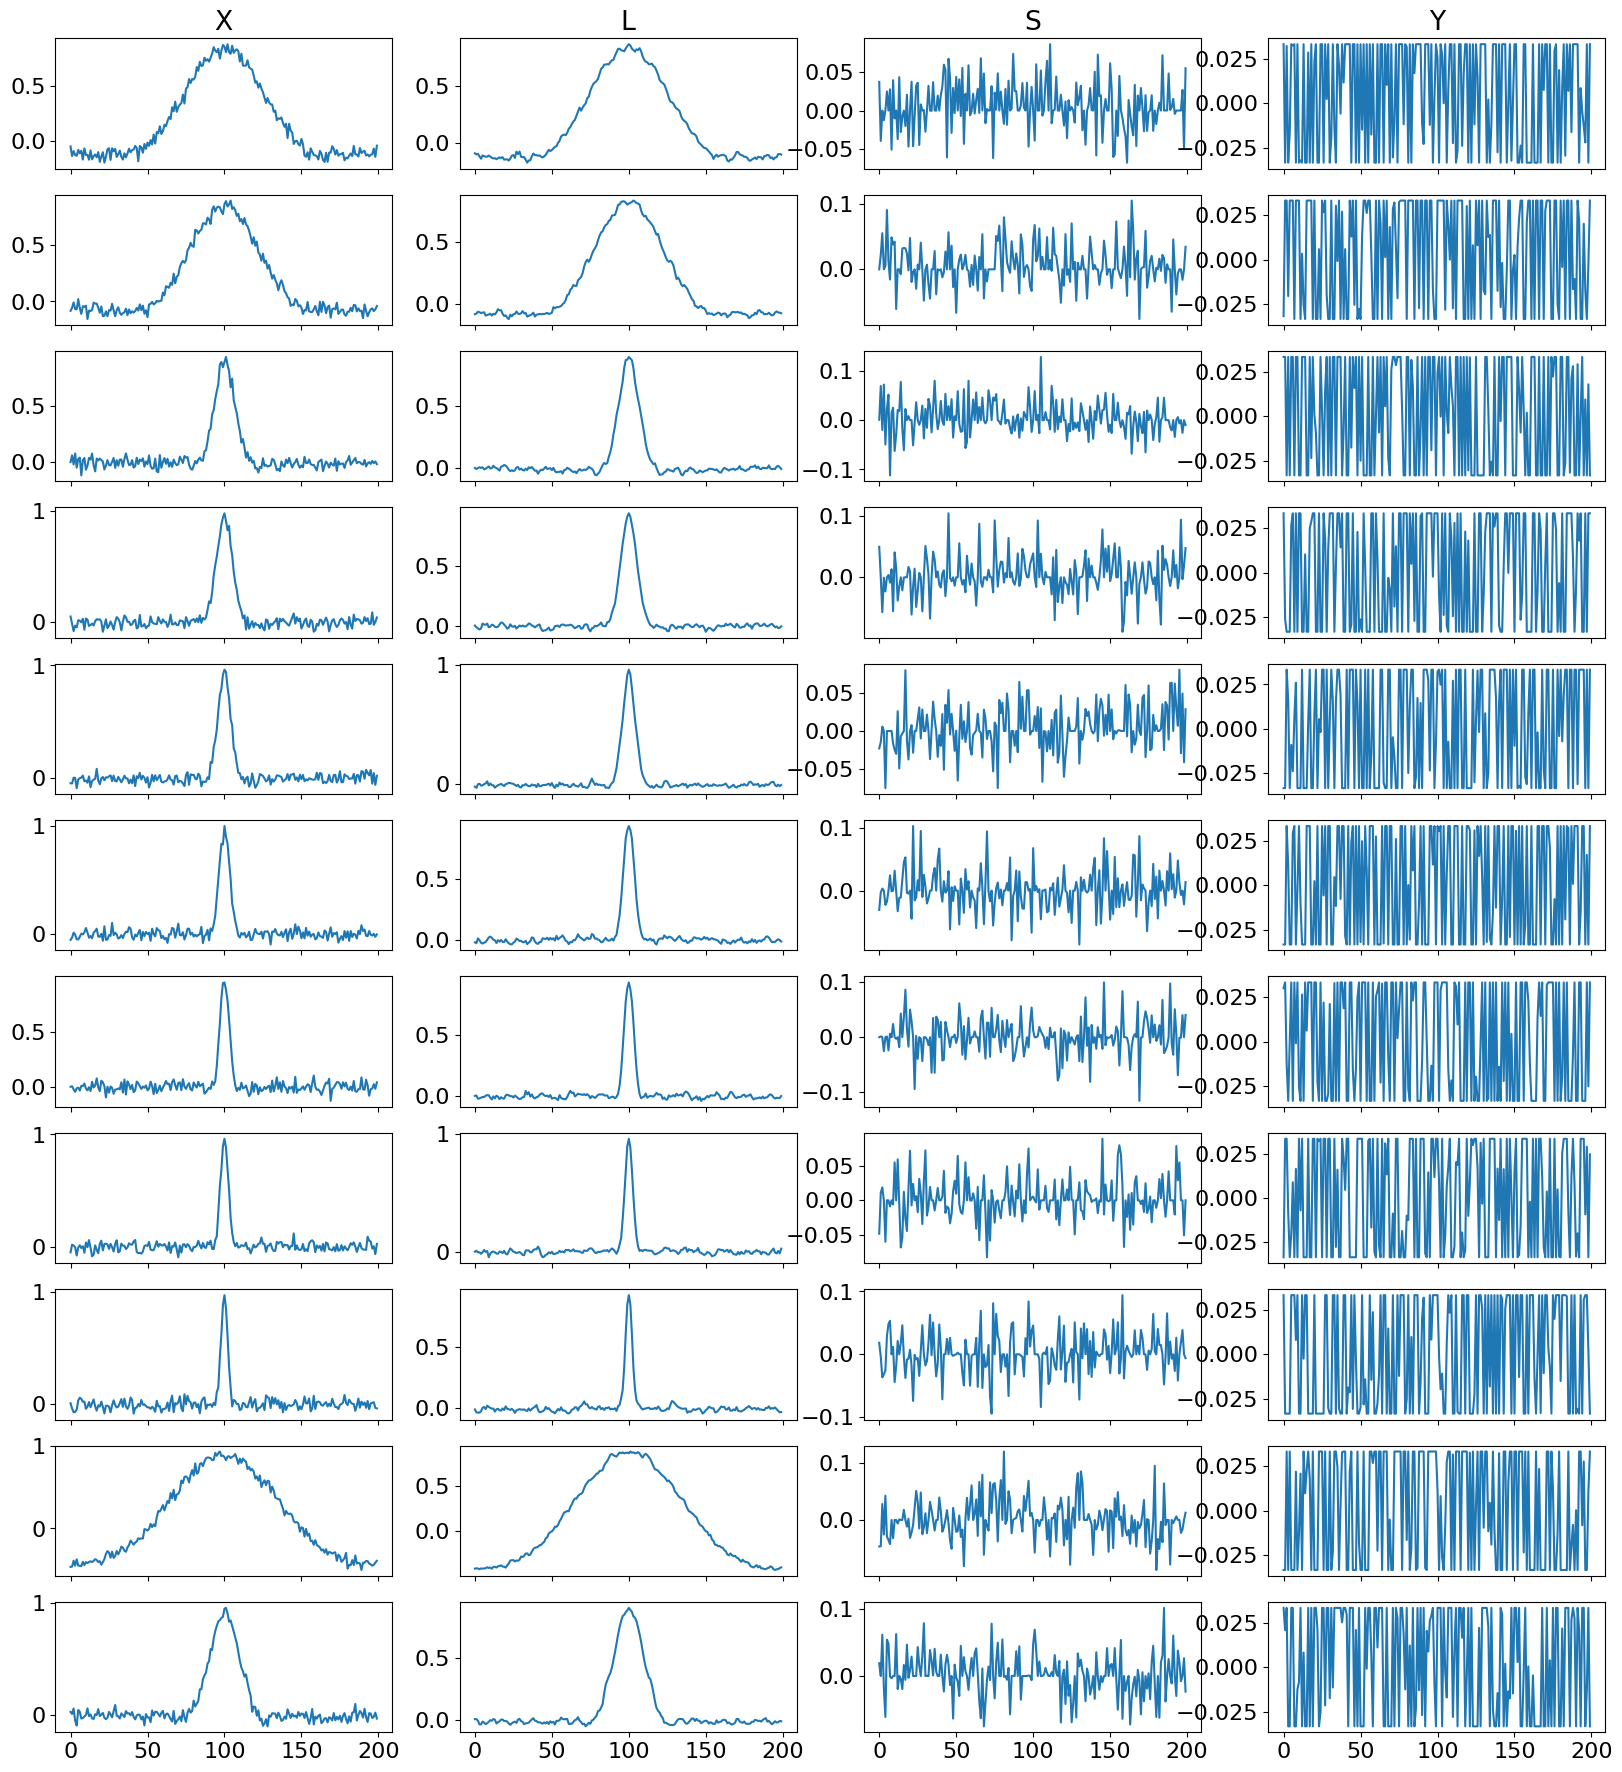

In [6]:
inds = (3,4,14,15,17,18,19,20,21,32,43)

fig, axs = plt.subplots(len(inds), 4, figsize= (20, 2*len(inds)), sharex= True)

axs[0,0].set(title= "X")
axs[0,1].set(title= "L")
axs[0,2].set(title= "S")
axs[0,3].set(title= "Y")

for ax_row, k in zip(axs, inds):
    ax_row[0].plot(training_interferograms[k].T)

    ax_row[1].plot(components[k].T)

    ax_row[2].plot(sparse_errors[k].T)

    ax_row[3].plot(lagrange_multiplier[k].T)

plt.show()

In [7]:
Q, R, permutation_matrix = spla.qr(components, pivoting= True)

print("Permutation Matrix (P):")
print(permutation_matrix)

Permutation Matrix (P):
[100  96  89 117  72 107  79  76 138  85 133 145 153  98   0  38 171  87
  91  17  59  34 148  10  41  23  20   7   4  12  70 156 185 175 173  32
 119 150  36  21  57  74  65   8 170   1 194  40  26 131 181  60  43 121
  28 149 125  88   3  35 136  77 108 155 187 169 178 128 183 192 123  37
  53 140 179  27 167   9 142 162 177 116  83  55 195  49  93 164 154  58
   2  80 176  11 110 188  90 129 166  25 161  67  61 182 165  15 118 106
  68 184  44  95 168 102 101 152 122 190  99 103  64  51 105  97  86 104
 109 132   5 111 115  52 127  94  29  19 114  48  92  66  22 120  75 113
  73 135 139  84  71 126 141  78 124  82 144  54 198  50 134 196 143  47
 112  81  16  69 158  62  45 146 147 130  31 199 193 174  30 159 197  18
 137   6  13  39 180  56 157 151 186  33  24  46 172  63 160 191 163  14
 189  42]


In [8]:
interferogram_to_test = 12

test_file_name = "1dmockanderrors{0:d}".format(interferogram_to_test)

test_interferogram, test_uncertainties = open_dataset(test_file_name, ".csv")

In [9]:
number_of_detectors = 8
regularization_coeffient = 1e-4

detectors = permutation_matrix[:number_of_detectors]

print(*np.sort(detectors), sep= ",")

72,76,79,89,96,100,107,117


In [10]:
samples = test_interferogram[detectors]
measurement_matrix = components[:,detectors]

lasso = Lasso(alpha= regularization_coeffient)
lasso.fit(measurement_matrix.T, samples)

result = np.matmul(components.T, lasso.coef_)

In [11]:
result2 = compressed_sensing(samples, detectors, 200, regularization_coeffient)

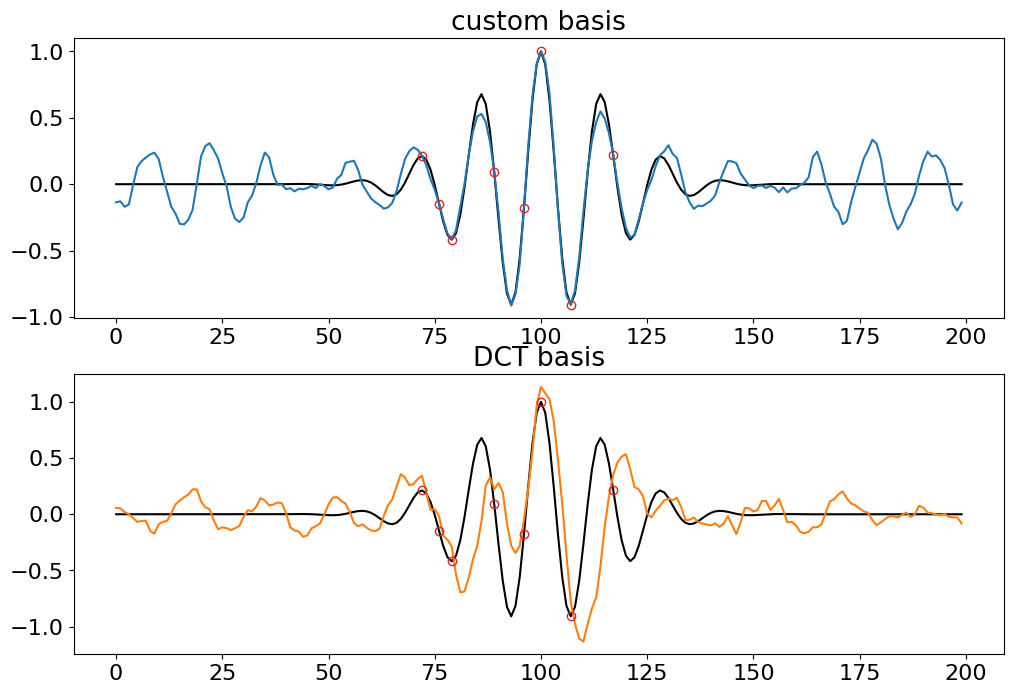

In [12]:
fig, axs = plt.subplots(2, 1, figsize= (12, 8))

axs[0].plot(test_interferogram, color= "k")
axs[0].plot(result, color= "tab:blue")
axs[0].plot(detectors, test_interferogram[detectors], color= "tab:red", marker= "o", linestyle= "none", markerfacecolor= "none")
axs[0].set(title= "custom basis")

axs[1].plot(test_interferogram, color= "k")
axs[1].plot(result2, color= "tab:orange")
axs[1].plot(detectors, test_interferogram[detectors], color= "tab:red", marker= "o", linestyle= "none", markerfacecolor= "none")
axs[1].set(title= "DCT basis")

plt.show()